In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from data_reader import read_consumption_and_weather
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [37]:
def preprocess():
    pass

In [38]:
df = read_consumption_and_weather()[-1]

df_no1 = df['NO1']
df_no1.loc[:,'region'] = 1

df_no2 = df['NO2']
df_no2.loc[:,'region'] = 2

df_no3 = df['NO3']
df_no3.loc[:,'region'] = 3

df_no4 = df['NO4']
df_no4.loc[:,'region'] = 4

df_no5 = df['NO5']
df_no5.loc[:,'region'] = 5

# combine all dataframes into one
df = pd.concat([df_no1, df_no2, df_no3, df_no4, df_no5])


# datetime features
dates = df.index
df['time_of_day'] = df.index.hour
df['time_of_week'] = df.index.dayofweek
df['time_of_month'] = df.index.day
df['time_of_year'] = df.index.month


df['consumption_24h_lag'] = df['consumption'].shift(24)#fillna(method='bfill')
df = df.dropna()
df['consumption_yday_mean'] = df['consumption'].shift(24).rolling(24).mean()#fillna(method='bfill')
df = df.dropna()
#df['consumption_prev'] = df['consumption'].shift(1)#fillna(method='bfill')
df = df.dropna()
df.head()


Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


C:\Users\Anders\AppData\Local\Temp\ipykernel_16696\2109659831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no1.loc[:,'region'] = 1
C:\Users\Anders\AppData\Local\Temp\ipykernel_16696\2109659831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no2.loc[:,'region'] = 2
C:\Users\Anders\AppData\Local\Temp\ipykernel_16696\2109659831.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,consumption,temperature,region,time_of_day,time_of_week,time_of_month,time_of_year,consumption_24h_lag,consumption_yday_mean
2017-05-03 23:00:00+00:00,2776.312998,10.2,1,23,2,3,5,2886.005008,3638.045293
2017-05-04 00:00:00+00:00,2729.629003,9.5,1,0,3,4,5,2870.407999,3623.894460
2017-05-04 01:00:00+00:00,2782.087997,9.3,1,1,3,4,5,2885.274001,3608.622501
2017-05-04 02:00:00+00:00,2825.548003,7.9,1,2,3,4,5,2887.499001,3590.076751
2017-05-04 03:00:00+00:00,2951.974004,7.2,1,3,3,4,5,2951.849002,3567.845918


In [39]:
def plot_losses(tr, va):
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots()
  ax.plot(tr, label='train')
  ax.plot(va, label='validation')
  plt.show()

In [40]:
df = df[['temperature', 'consumption', 'consumption_24h_lag', 'region', 'time_of_day', 'time_of_week', 'time_of_year', 'consumption_yday_mean']]
#df = df[['temperature', 'consumption']]
df.head()

,temperature,consumption,consumption_24h_lag,region,time_of_day,time_of_week,time_of_year,consumption_yday_mean
2017-05-03 23:00:00+00:00,10.2,2776.312998,2886.005008,1,23,2,5,3638.045293
2017-05-04 00:00:00+00:00,9.5,2729.629003,2870.407999,1,0,3,5,3623.894460
2017-05-04 01:00:00+00:00,9.3,2782.087997,2885.274001,1,1,3,5,3608.622501
2017-05-04 02:00:00+00:00,7.9,2825.548003,2887.499001,1,2,3,5,3590.076751
2017-05-04 03:00:00+00:00,7.2,2951.974004,2951.849002,1,3,3,5,3567.845918


In [41]:
target_feature = 'consumption'
#features = list(df.columns.difference([target_feature])) #kanskje bruk denne istedenfor
features = list(df.columns)
print("features: ", len(features))
forecast_lead = 1
target = f"{target_feature}_lead{forecast_lead}"

df[target] = df[target_feature].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

df.tail()

features:  8


,temperature,consumption,consumption_24h_lag,region,time_of_day,time_of_week,time_of_year,consumption_yday_mean,consumption_lead1
2023-01-21 18:00:00+00:00,2.1,2353.881705,2462.145900,5,18,5,1,2354.136122,2300.132978
2023-01-21 19:00:00+00:00,2.3,2300.132978,2426.738580,5,19,5,1,2356.627090,2256.769569
2023-01-21 20:00:00+00:00,2.5,2256.769569,2380.399471,5,20,5,1,2358.174320,2218.865366
2023-01-21 21:00:00+00:00,2.8,2218.865366,2333.329640,5,21,5,1,2359.547858,2180.153230
2023-01-21 22:00:00+00:00,3.1,2180.153230,2295.309347,5,22,5,1,2361.402647,2134.474542


In [42]:
validation_start = "2022-01-01"
test_start = "2022-06-20"

df_train = df.loc[:validation_start].copy()
df_val = df.loc[validation_start:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.10327611488317236


In [43]:
# scale
mean = df_train.mean()
std = df_train.std()

def scale(df, mean, std):
  df[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_lead1']] = \
    (df[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_lead1']]\
      -mean[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_lead1']])\
        /std[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_lead1']]
  return df

df_train = scale(df_train, mean, std)
df_val = scale(df_val, mean, std)
df_test = scale(df_test, mean, std)




In [44]:
df_train.tail()

,temperature,consumption,consumption_24h_lag,region,time_of_day,time_of_week,time_of_year,consumption_yday_mean,consumption_lead1
2022-01-01 19:00:00+00:00,0.176706,-0.812833,-0.848767,5,19,5,1,-0.853229,-0.849998
2022-01-01 20:00:00+00:00,0.203883,-0.849985,-0.877159,5,20,5,1,-0.856582,-0.882539
2022-01-01 21:00:00+00:00,0.231059,-0.882526,-0.898119,5,21,5,1,-0.859169,-0.920161
2022-01-01 22:00:00+00:00,0.258236,-0.920149,-0.918242,5,22,5,1,-0.860708,-0.952852
2022-01-01 23:00:00+00:00,0.299000,-0.952839,-0.931685,5,23,5,1,-0.861172,-0.983324


In [45]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=24):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.Tensor(dataframe[target].values).float()
        self.X = torch.Tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if idx >= self.sequence_length - 1:
            i_start = idx - self.sequence_length + 1
            x = self.X[i_start:(idx + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - idx - 1, 1)
            x = self.X[0:(idx + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[idx]

In [46]:
torch.manual_seed(42)

batch_size = 32
sequence_length = 24

train_dataset = SequenceDataset(
    df_train, 
    target = target, 
    features = features, 
    sequence_length=sequence_length
)

val_dataset = SequenceDataset(
    df_val,
    target = target,
    features = features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target = target,
    features = features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: torch.Size([32, 48, 8])
Target shape: torch.Size([32])


In [47]:
class LSTMModel(nn.Module):
    def __init__(self, num_features, hidden_units, use_cuda=False):
        super().__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = 10

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear1 = nn.Linear(in_features=hidden_units*48, out_features=32).cuda(),
        self.linear2 = nn.Linear(in_features=32, out_features=1).cuda()


        if use_cuda:
            self.cuda()

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).cuda()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).cuda()


        self.hidden = (c0, h0)
        x, h = self.lstm(x, self.hidden)
        x = x.contiguous().view(x.shape[0], -1)
        #x = torch.relu(self.linear1(x))
        x = self.linear1[0](x)
        x = self.linear2(x)
        return x

In [48]:
lr = 5e-5
num_hidden_units = 128

model = LSTMModel(num_features=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

gpu: True
0 - train: 0.06949174125453282, valid: 0.051082908133816586
1 - train: 0.027307050669114687, valid: 0.035464888408118594
2 - train: 0.020471741663532158, valid: 0.025967781640867764
3 - train: 0.01680993892310653, valid: 0.024613209937356783
4 - train: 0.013730116401907253, valid: 0.019761572778007348
5 - train: 0.007193361923327757, valid: 0.026261883729784472
6 - train: 0.003376766060931686, valid: 0.011244666791028514
7 - train: 0.0022477902981199805, valid: 0.01702517322395171
8 - train: 0.0017765961957968556, valid: 0.01437800056245751
9 - train: 0.0015668634175756324, valid: 0.015149738193561055


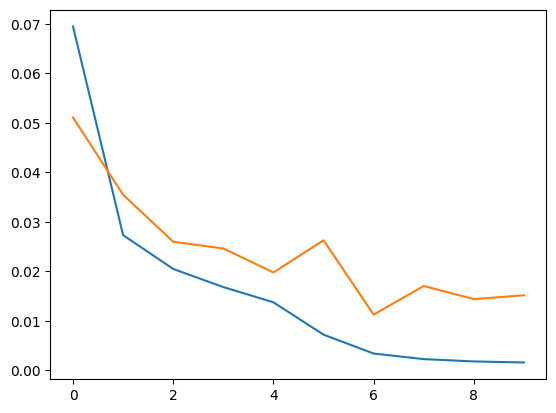

In [49]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(f"gpu: {USE_CUDA}")
model = lr = 5e-5
num_hidden_units = 16

model = LSTMModel(num_features=len(features), hidden_units=num_hidden_units, use_cuda=USE_CUDA).to(device)

lr = 4e-4
n_epochs = 10
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


t_losses, v_losses = [], []

for epoch in range(n_epochs):
    train_loss, val_loss = 0.0, 0.0

    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()

        x = x.to(device)
        #y = y.squeeze().to(device)
        y = y.unsqueeze(1).to(device)
        #print(f"x shape: {x.shape}, y shape: {y.shape}")
        #print(x)
        preds = model(x)#.squeeze()
        #print(f"preds shape: {preds.shape}")
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_loader)
    t_losses.append(epoch_loss)

    # validation
    model.eval()
    for x, y in val_loader:
        with torch.no_grad():
            x = x.to(device)
            y = y.squeeze().to(device)
            preds = model(x).squeeze()
            error = criterion(preds, y)
        val_loss += error.item()
    val_loss = val_loss / len(val_loader)
    v_losses.append(val_loss)

    print(f'{epoch} - train: {epoch_loss}, valid: {val_loss}')

plot_losses(t_losses, v_losses)


In [57]:
# save the model
torch.save(model.state_dict(), './saved_models/lstm_model.pt')

In [50]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
  model.eval()
  predictions, actuals = [], []
  device = next(model.parameters()).device
  for x, y in unshuffled_dataloader:
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
      p = model(x)
      predictions.append(p)
      actuals.append(y.squeeze())
  predictions = torch.cat(predictions).cpu().numpy()
  actuals = torch.cat(actuals).cpu().numpy()
  return predictions.squeeze(), actuals


In [51]:
preds, actuals = make_predictions_from_dataloader(model, test_loader)

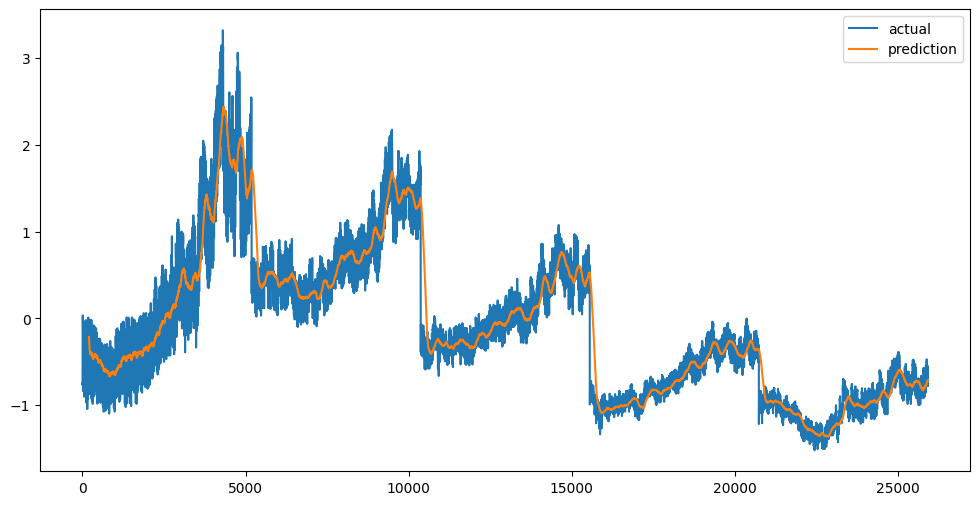

In [52]:
# plot the predictions vs the actuals witht the predictions as an average line
window_size = 200

# calculate the moving average of the predictions
moving_preds = np.convolve(preds, np.ones(window_size)/window_size, mode='valid')

# plot the actuals and smoothed predictions
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='actual')
plt.plot(np.arange(window_size-1, len(preds)), moving_preds, label='prediction')
plt.legend()
plt.show()

In [169]:
def forecast(dataloader, df_to_plot, batch_num:int=3, fw:int=24):
    """
    fw: forecast window
    """
    predictions = {i: [] for i in range(len(test_loader))}
    prev_y_ind = 1 # lag of the consumption
    df_start_ind = fw * batch_num # indexes for accessing 
    df_end_ind = fw * (batch_num + 1)
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            x, y = data
            current_input = x.to(device)
            
            for _ in range(fw):
                # Use the current input to make a prediction
                prediction = model(current_input)

                # Add the prediction to the list of predictions
                predictions[i].append(prediction.cpu().numpy())

                # delete the first timestep from the input and add the forecast to the end
                current_input[:, :-1, prev_y_ind] = current_input[:, 1:, prev_y_ind]
                current_input[:, -1, prev_y_ind] = torch.from_numpy(prediction.squeeze().cpu().numpy()).to(device) 

    targets_to_plot = df_to_plot.iloc[df_start_ind:df_end_ind]['consumption_lead1'].reset_index(drop=True)
    preds_to_plot = pd.Series(np.array(predictions[batch_num]).squeeze()[:,0])
    res_df = pd.concat([targets_to_plot, preds_to_plot], axis=1)
    res_df.rename(columns={"consumption_lead1": "target",
                           0: "pred"}, inplace=True)
    ## unscale the data
    # res_df = res_df * std['consumption_lead1'] + mean['consumption_lead1']
    return res_df

In [170]:
# batch 3
res = forecast(test_loader, df_test, 3, 24, True)

In [205]:
def plot_forecast(test_loader, df_test, mean, std, batch_no, seq_len, fw):
    res = forecast(test_loader, df_test, batch_no, fw, False)
    start_ind = seq_len * batch_no
    end_ind = start_ind + seq_len + fw
    targets_to_plot = df_test.iloc[start_ind:end_ind]['consumption_lead1'].rename('target')
    preds_to_plot = res.iloc[:,1]
    last_time_ind = targets_to_plot.index[-(fw+1)]
    preds_to_plot.index = pd.date_range(start=last_time_ind, periods=fw, freq='H')
    res_df = pd.concat([targets_to_plot, preds_to_plot], axis=1)
    # unscale the data
    res_df = res_df * std['consumption_lead1'] + mean['consumption_lead1']

    # calculate the error
    res["error"] = (res["target"] - res["pred"]).abs()
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
    ax1.plot(res_df.iloc[:,0], label='actual')
    ax1.plot(res_df.iloc[:,1], label='pred')
    ax1.set_title("Forecast")
    ax2.plot(res["error"])
    ax2.set_title("target vs forecast")
    plt.legend()
    plt.show()
    return res_df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


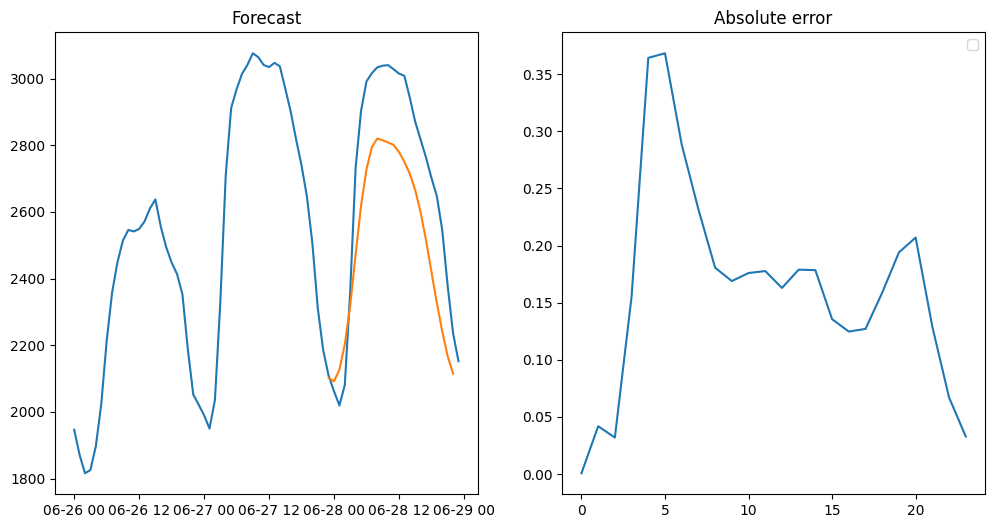

In [206]:
res = plot_forecast(test_loader, df_test, mean, std, 3, 48, 24)

In [207]:
# calculate the error 
res["error"] = (res["target"] - res["pred"]).abs()



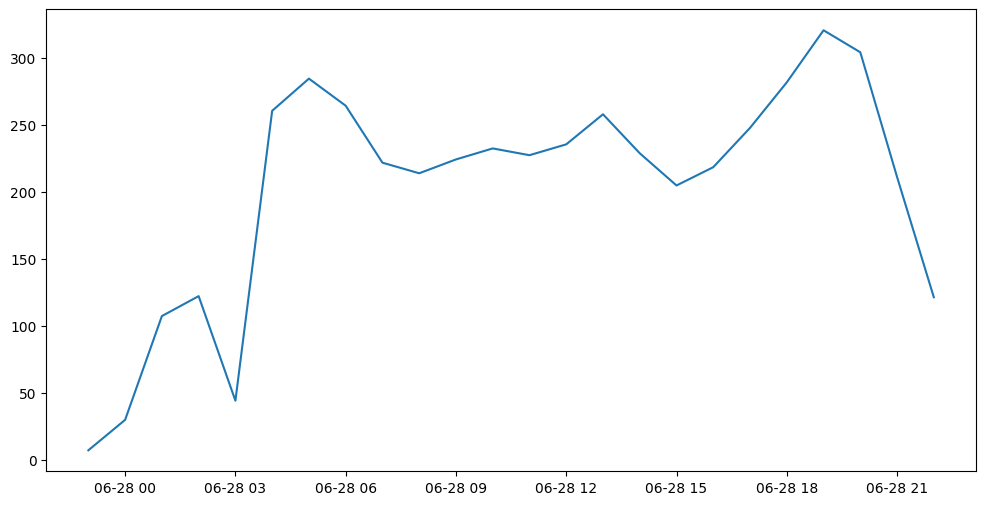

In [208]:
# plot the error
plt.figure(figsize=(12,6))
plt.plot(res["error"])
plt.show()